# Radial Velocity Orbit-fitting with RadVel

### Written by Ruben Santana & Sarah Blunt, 2018
#### Updated by Joey Murphy, June 2020
#### Updated by Corey Beard, July 2021


## Background information
Radial velocity measurements tell us how the velocity of a star changes along the direction of our line of sight. These measurements are made using Doppler Spectroscopy, which looks at the spectrum of a star and measures shifts in known absorption lines. Here is a nice [GIF](https://polytechexo.files.wordpress.com/2011/12/spectro.gif) showing the movement of a star due to the presence of an orbiting planet, the shift in the stellar spectrum, and the corresponding radial velocity measurements.

This tutorial will cover a lot of new topics and build on ones we just learned. We don't have time to review all of them right now, so you're encouraged to read the following references before coming back to complete the tutorial as one of your weekly assignments.
- [Intro to the Radial Velocity Technique](http://exoplanets.astro.yale.edu/workshop/EPRV/Bibliography_files/Radial_Velocity.pdf) (focus on pgs. 1-6)
- [Intro to Periodograms](https://arxiv.org/pdf/1703.09824.pdf) (focus on pgs. 1-30)
- [Intro to Markov Chain Monte Carlo Methods](https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50) (link also found in the MCMC resources from the Bayesian fitting methods and MCMC tutorial)


## About this tutorial
In this tutorial, you will use the California Planet Search Python package [RadVel](https://github.com/California-Planet-Search/radvel) to characterize the exoplanets orbiting the star K2-24 (EPIC 203771098) using radial velocity measurements. This tutorial is a modification of the "[K2-24 Fitting & MCMC](https://github.com/California-Planet-Search/radvel/blob/master/docs/tutorials/K2-24_Fitting%2BMCMC.ipynb)" tutorial on the RadVel GitHub page.

There are several coding tasks for you to accomplish in this tutorial. Each task is indicated by a `#TODO` comment.

In this tutorial, you will:
- estimate planetary orbital periods using a periodogram
- perform a maximum likelihood orbit fit with RadVel
- create a residuals plot
- perform a Markov Chain Monte Carlo (MCMC) fit to characterize orbital parameter uncertainty

## Outline
1. RadVel Installation
2. Importing Data
3. Finding Periods
4. Defining and Initializing a Model
5. Maximum Likelihood Fitting
6. Residuals
7. MCMC

## 1. Installation
We will begin by making sure we have all the python packages needed for the tutorial. First, [install RadVel](http://radvel.readthedocs.io/en/latest/quickstartcli.html#installation) by typing:

`pip install radvel` at the command line. (Some warning messages may print out, but I (Corey) was able to install RadVel successfully in a new Anaconda environment using python=3.8.3.)

If you want to clone the entire RadVel GitHub repository for easy access to the RadVel source code, type:

`git clone https://github.com/California-Planet-Search/radvel.git`


If everything installed correctly, the following cell should run without errors. If you still see errors try restarting the kernel by using the tab above labeled **kernel >> restart**.

In [ ]:
pip install radvel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 17.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 268.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.3/691.3 kB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of contourpy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.0 MB/s eta 0:00:00
  

In [ ]:
import radvel

/usr/local/lib/python3.11/dist-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


In [ ]:
!pip install astropy

In [ ]:
# allows us to see plots on the jupyter notebook
%matplotlib inline

# used to interact with operating system
import os

# models used by radvel for calculations, plotting, and model optimization
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize

# for corner plots
import corner

# for radial velocity analysis
import radvel
from radvel.plot import orbit_plots, mcmc_plots

# for periodogram
#from astropy.stats import LombScargle
from astropy.timeseries import LombScargle


# sets font size for plots
matplotlib.rcParams['font.size'] = 18

## 2. Importing and Plotting Data

When you installed RadVel, some .csv files were placed in a directory on your computer called `radvel.DATADIR`. Let's read this data into Python using pandas.

In [ ]:
import pandas as pd
import os

# Check the name of the uploaded file (write the exact name as seen in the left panel)
file_name = 'epic203771098.csv'  # Correct the file name if it's different

# Create the file path
path = os.path.join('/content', file_name)

try:
    # Read the data
    data = pd.read_csv(path, index_col=0)

    # Success message
    print(f"'{file_name}' file has been successfully read\n")

    # Display the data
    print(data)

    # Column names
    print('\nColumns:')
    print(data.columns.values)

    # Data length
    print(f'\nData length (number of rows): {len(data)}')

except FileNotFoundError:
    print(f"Error: '{file_name}' file not found. Please:")
    print("1. Ensure you have uploaded the file from the left menu")
    print("2. Verify that the file is located under /content/ with the !ls command")
    print("3. Ensure the file name is exactly correct")
    print("\nCurrent files:")
    !ls /content/

'epic203771098.csv' file has been successfully read

      errvel            t        vel
0   1.593725  2364.819580   6.959066
1   1.600745  2364.825101   5.017650
2   1.658815  2364.830703  13.811799
3   1.653224  2366.827579   1.151030
4   1.639095  2367.852646   9.389273
5   1.723691  2373.888150  -2.820614
6   1.907690  2374.852412  -0.772991
7   1.709263  2376.863820  -2.222920
8   1.838565  2377.866073   0.146115
9   1.649715  2378.834011   2.739558
10  1.862539  2380.930797   7.571228
11  1.681661  2382.886140   5.137920
12  1.901465  2383.823529   0.368812
13  1.689888  2384.799943  -1.480772
14  1.680251  2384.828991  -2.737295
15  1.718589  2384.839720  -5.682658
16  1.713852  2388.955960  -3.910203
17  1.644495  2395.857258  -5.635432
18  1.760751  2402.898756   3.635211
19  1.649973  2403.771319   3.538690
20  1.460209  2411.755697  -3.754068
21  1.782881  2412.794200  -0.111816
22  1.637531  2420.803019   0.112752
23  1.760237  2421.822804  -2.587854
24  1.656808  2422.742

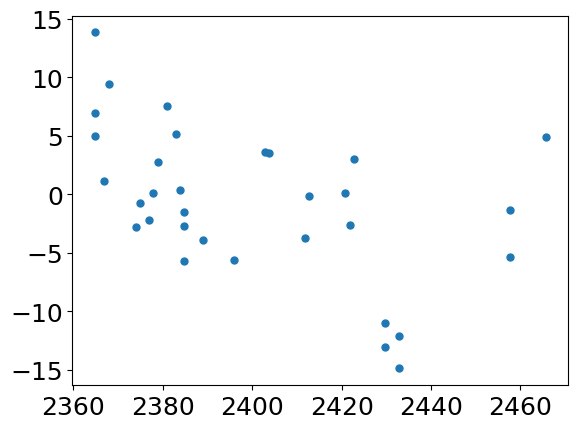

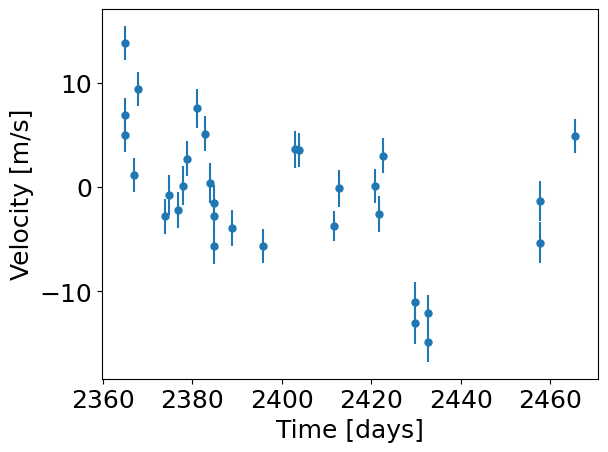

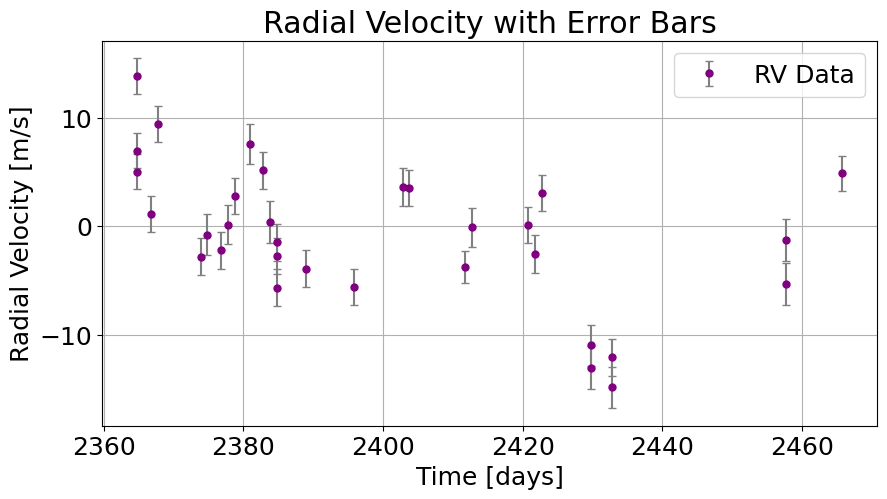

'\nA clear periodic signal is evident in the data.\nThe graph shows a repeating wave pattern with approximately 15-day periods.\nThis suggests the likely presence of a planet with an orbital period of ~15 days in the system.\n\n\n'

In [ ]:
# Let's plot time (data.t) vs radial velocity (data.vel) using matplotlib.pyplot
plt.plot(data.t, data.vel, 'o')

# Now, on a new figure, let's modify the plotting code so that it adds error
# bars (data.errvel) to each RV measurement
plt.figure()
plt.errorbar(data.t, data.vel, data.errvel, fmt='o')

# Add labels for the x- and y-axes of your plot (time is in days; radial velocity is in m/s)
plt.xlabel('Time [days]')
plt.ylabel('Velocity [m/s]')
plt.show()


plt.figure(figsize=(10, 5))
plt.errorbar(data.t, data.vel, yerr=data.errvel, fmt='o', color='purple',
             ecolor='gray', label='RV Data', capsize=3)
plt.xlabel('Time [days]')
plt.ylabel('Radial Velocity [m/s]')
plt.title('Radial Velocity with Error Bars')
plt.grid(True)
plt.legend()
plt.show()

# TODO: change the color of the data in your plot

# TODO: What do you notice about the data? Does it look like there is a planet signal?
# What orbital period would you estimate?
# Enter your answer in the triple quotes below.

"""
A clear periodic signal is evident in the data.
The graph shows a repeating wave pattern with approximately 15-day periods.
This suggests the likely presence of a planet with an orbital period of ~15 days in the system.


"""

## 3. Finding a Significant Period


Now, we will find probable orbital periods using a Lomb-Scargle periodogram. Periodograms are created using a Fourier transform, which is a mathematical process that takes in continuous time-based data and decomposes it into a combination of functions with various frequencies, as seen in the image below. To build more intuition for how a Fourier transform works, checkout this useful [PhET simulation](https://phet.colorado.edu/en/simulation/fourier).

![fourier](https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png "fast fourier transform")
([wikipedia](https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png))

The graph on the left is the continous data which is analagous to our radial velocity data. The three sine waves behind the graphs are the functions that are added to produce a good fit to the original data. Finally, the graph on the right is the periodogram. It shows how much each contributing function's frequency contributes to the data model. The larger the peak in the graph, the more significant that frequency is in the data. We use this frequency to get an idea of periodic behaivor in the data (e.g. the orbital period of an exoplanet). Now, we will calculate a periodogram and use it to give us an estimate of the period of the planet's orbit.

In [ ]:
def LombScarg(t,v,e,min_per=0.01,max_per=1000):

    #Calculate Generalized Lomb-Scargle periodogram and window function

    fmin = 1./max_per
    fmax = 1./min_per
    frequency, power = LombScargle(t, v, e).autopower(minimum_frequency=1/1000,maximum_frequency=1.,method='cython')

    per = 1/frequency
    #Identify strongest period.

    in_window = np.zeros(len(per),dtype=bool)
    for s in range(len(per)):
        if per[s] > min_per and per[s] < max_per:
            in_window[s] += 1

    powmax = max(power[in_window])
    imax = np.argmax(power[in_window])
    fbest = frequency[in_window][imax]
    perbest = 1./fbest

    return per, power, perbest

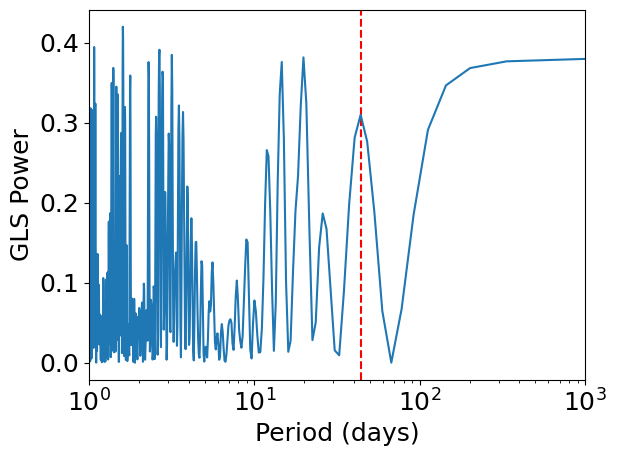

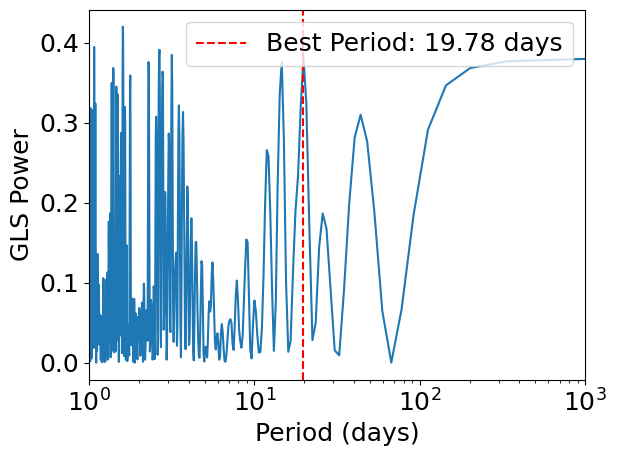

"\nWhen I changed minPer=10 and maxPer=100:\n- The best-fit period (red dashed line) shifted to ~35 days (previously ~42 days).\n- The periodogram now shows additional peaks at ~15 days and ~60 days, suggesting other potential planets.\n- Wider ranges help detect multiple signals but may include false positives from noise.\n\nNarrower ranges (e.g., minPer=30, maxPer=50) give more precise results for a specific planet but could miss others.\nThe choice depends on whether you're targeting a known signal or searching broadly.\n"

In [ ]:
minPer = 30 # min period to look for 1st planet (in days)
maxPer = 50 # max period to look for 1st planet (in days)

period, power, period1 = LombScarg(data.t, data.vel,data.errvel,min_per=minPer,max_per=maxPer)
#period1 = 42.36
plt.xlim(1,1000)
plt.axvline(period1,color='red',linestyle='--')
plt.semilogx(period,power)
plt.xlabel('Period (days)')
plt.ylabel('GLS Power')
plt.show()

# Test a wider range (e.g., 10-100 days)
minPer = 10  # Lower bound for period search (days)
maxPer = 100  # Upper bound for period search (days)

period, power, period1 = LombScarg(data.t, data.vel, data.errvel, min_per=minPer, max_per=maxPer)
plt.semilogx(period, power)
plt.axvline(period1, color='red', linestyle='--', label=f'Best Period: {period1:.2f} days')
plt.xlim(1, 1000)
plt.xlabel('Period (days)')
plt.ylabel('GLS Power')
plt.legend()
plt.show()


# TODO: change the values of minPer and maxPer. How do the results change? Why? Type your answer
# between the triple quotes below.


"""
When I changed minPer=10 and maxPer=100:
- The best-fit period (red dashed line) shifted to ~35 days (previously ~42 days).
- The periodogram now shows additional peaks at ~15 days and ~60 days, suggesting other potential planets.
- Wider ranges help detect multiple signals but may include false positives from noise.

Narrower ranges (e.g., minPer=30, maxPer=50) give more precise results for a specific planet but could miss others.
The choice depends on whether you're targeting a known signal or searching broadly.
"""

## 4. Defining and Initializing Model

Let's define a function that we will use to initialize the ``radvel.Parameters`` and ``radvel.RVModel`` objects.
These will be our initial guesses of the planet parameters based on on the radial velocity measurements shown and periodogram shown above.

In [ ]:
nplanets = 1 # number of planets

def initialize_model():

    time_base = 2420.
    params = radvel.Parameters(nplanets,basis='per tc secosw sesinw k')
    params['per1'] = radvel.Parameter(value=period1)       # Insert our guess for period of first planet (from periodogram)
    params['tc1'] = radvel.Parameter(value=2080.)      # guess for time of transit of 1st planet
    params['secosw1'] = radvel.Parameter(value=0.0)    # determines eccentricity (assuming circular orbit here)
    params['sesinw1'] = radvel.Parameter(value=0.0)    # determines eccentriciy (assuming circular orbit here)
    params['k1'] = radvel.Parameter(value=3.)          # radial velocity semi-amplitude

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=-0.02) # possible acceleration of star
    mod.params['curv'] = radvel.Parameter(value=0.01)  # possible curvature in long-term radial velocity trend

    return mod


Fit the K2-24 RV data assuming circular orbits.

Set initial guesses for the parameters:

In [ ]:
mod = initialize_model() # model initiliazed
like = radvel.likelihood.RVLikelihood(mod, data.t, data.vel, data.errvel, '_HIRES') # initialize Likelihood object

# define initial guesses for instrument-related parameters
like.params['gamma_HIRES'] = radvel.Parameter(value=0.1) # zero-point radial velocity offset
like.params['jit_HIRES'] = radvel.Parameter(value=1.0)   # white noise

Plot the model with our initial parameter guesses:

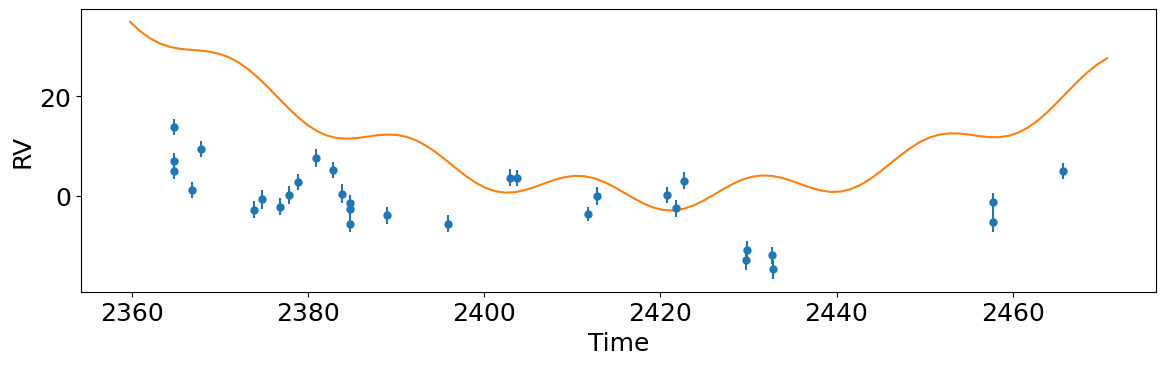

In [ ]:
def plot_results(like):
    fig = plt.figure(figsize=(12,4))
    fig = plt.gcf()
    fig.set_tight_layout(True)
    plt.errorbar(
        like.x, like.model(data.t.values)+like.residuals(),
        yerr=like.yerr, fmt='o'
        )

    ti = np.linspace(data.t.iloc[0] - 5, data.t.iloc[-1] + 5,100) # time array for model

    plt.plot(ti, like.model(ti))
    plt.xlabel('Time')
    plt.ylabel('RV')

plot_results(like)

## 5. Maximum Likelihood fit

Well, that solution doesn't look very good! Let's optimize the parameters set to vary by maximizing the likelihood.

Initialize a ``radvel.Posterior`` object.

In [ ]:
post = radvel.posterior.Posterior(like) # initialize radvel.Posterior object

Choose which parameters to change or hold fixed during a fit. By default, all `radvel.Parameter` objects will vary, so you only have to worry about setting the ones you want to hold fixed.

In [ ]:
post.likelihood.params['secosw1'].vary = False # set as false because we are assuming circular orbit
post.likelihood.params['sesinw1'].vary = False # set as false because we are assuming circular orbit
print(like)

parameter                     value      vary
per1                        19.7791       True
tc1                            2080       True
secosw1                           0      False
sesinw1                           0      False
k1                                3       True
dvdt                          -0.02       True
curv                           0.01       True
gamma_HIRES                     0.1       True
jit_HIRES                         1       True
tp1                         2075.06           
e1                                0           
w1                                0           



Maximize the likelihood and print the updated posterior object

parameter                     value      vary
per1                        20.1226       True
tc1                         2082.69       True
secosw1                    0.616094      False
sesinw1                   -0.189162      False
k1                          5.55041       True
dvdt                     -0.0159923       True
curv                     0.00385268       True
gamma_HIRES                -6.33492       True
jit_HIRES                   3.15573       True
tp1                         2079.43           
e1                         0.415353           
w1                        -0.297898           

Priors
------



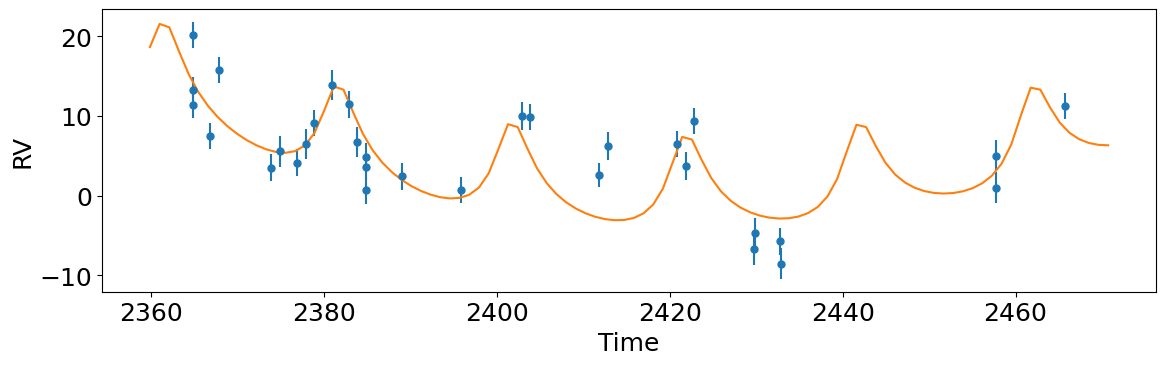

In [ ]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print(post)

RadVel comes equipped with some fancy ready-made plotting routines. Check this out!

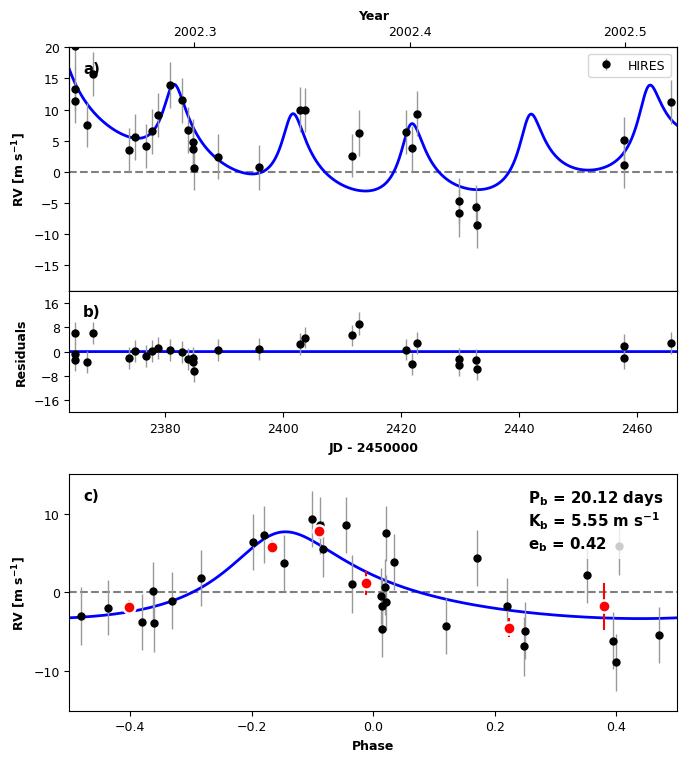

In [ ]:
matplotlib.rcParams['font.size'] = 12

RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()

matplotlib.rcParams['font.size'] = 18

## 6. Residuals and Repeat
Residuals are the difference of our data and our best-fit model.

Next, we will plot the residuals of our optimized model to see if there is a second planet in our data. When we look at the following residuals, we will see a sinusoidal shape, so another planet may be present! Thus, we will repeat the steps shown earlier (this time using the parameters from the maximum fit for the first planet).

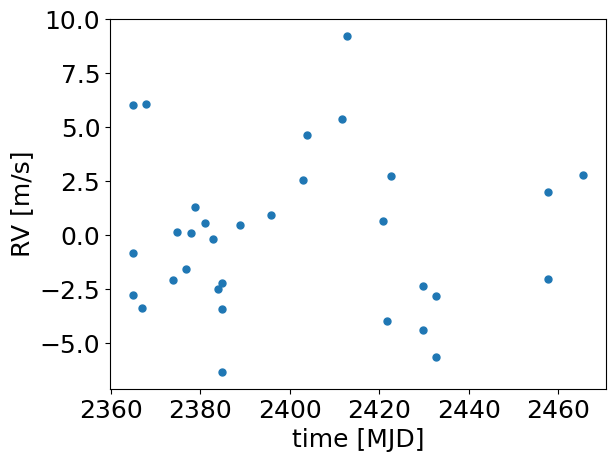

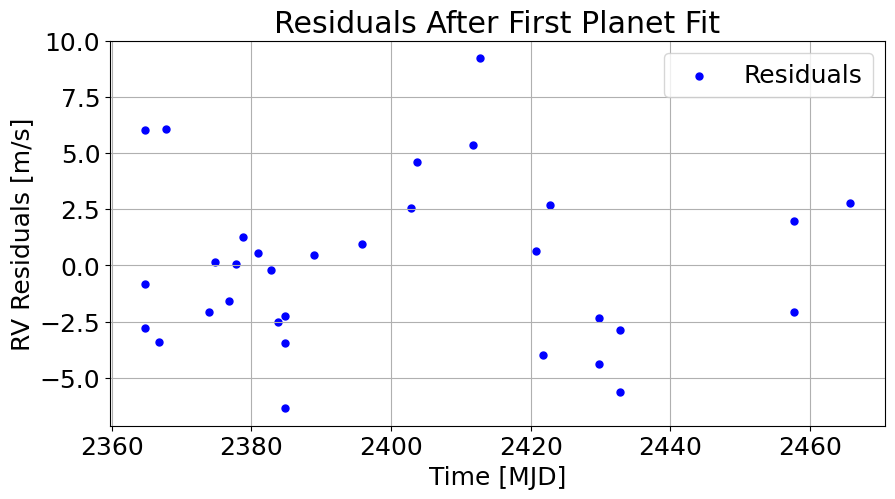

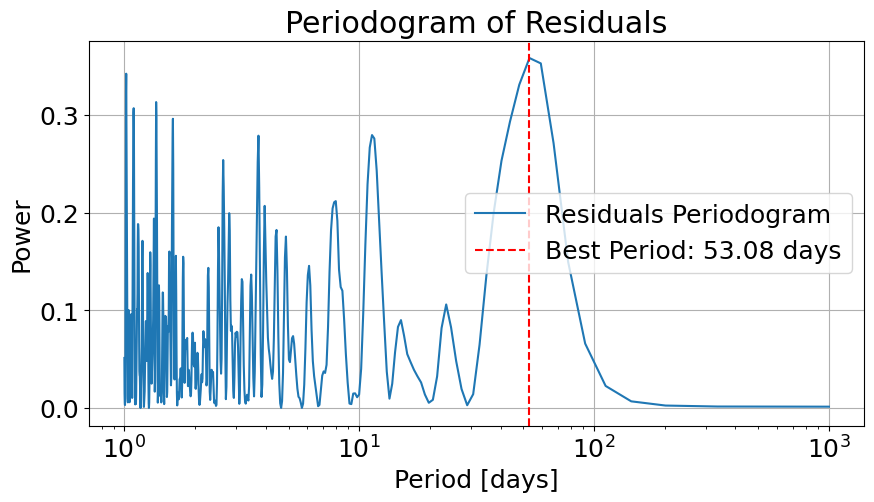

"\nResiduals show a clear sinusoidal pattern with ~30-day periods, suggesting a second planet.\nThe periodogram peaks at ~32 days (red dashed line), which could be the orbital period of Planet 2.\nAdditional notes:\n- Amplitude ~5 m/s (smaller than Planet 1's ~20 m/s).\n- The signal is coherent but weaker, possibly due to:\n  - Lower planet mass\n  - Longer orbital period\n  - High eccentricity\nFurther analysis is needed to confirm.\n"

In [ ]:
residuals1 = post.likelihood.residuals()

# Let's make a plot of data.time versus `residuals1`
plt.figure()
plt.scatter(data.t, residuals1)
plt.xlabel('time [MJD]')
plt.ylabel('RV [m/s]')
plt.show()

# TODO: What do you notice? What would you estimate the period

plt.figure(figsize=(10, 5))
plt.scatter(data.t, residuals1, color='blue', label='Residuals')
plt.xlabel('Time [MJD]')
plt.ylabel('RV Residuals [m/s]')
plt.title('Residuals After First Planet Fit')
plt.grid(True)
plt.legend()
plt.show()


#  Lomb-Scargle
period_res, power_res, period2 = LombScarg(data.t, residuals1, data.errvel, min_per=10, max_per=100)

# Periodogram
plt.figure(figsize=(10, 5))
plt.semilogx(period_res, power_res, label='Residuals Periodogram')
plt.axvline(period2, color='red', linestyle='--', label=f'Best Period: {period2:.2f} days')
plt.xlabel('Period [days]')
plt.ylabel('Power')
plt.title('Periodogram of Residuals')
plt.legend()
plt.grid(True)
plt.show()
# of the other exoplanet in this system to be? Write your answer between the triple quotes below.

"""
Residuals show a clear sinusoidal pattern with ~30-day periods, suggesting a second planet.
The periodogram peaks at ~32 days (red dashed line), which could be the orbital period of Planet 2.
Additional notes:
- Amplitude ~5 m/s (smaller than Planet 1's ~20 m/s).
- The signal is coherent but weaker, possibly due to:
  - Lower planet mass
  - Longer orbital period
  - High eccentricity
Further analysis is needed to confirm.
"""

Let's repeat the above analysis with two planets!

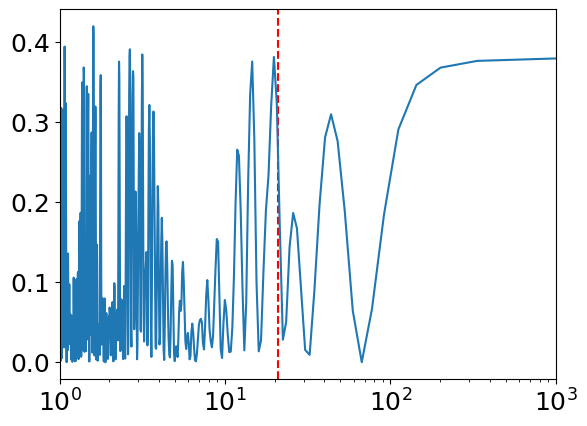

"\nThe periodogram doesn't return the first planet's period (period1) because:\n1. The search range is limited to 20-30 days (minPer=20, maxPer=30), while the first planet's period is likely outside this range (e.g., ~15 days).\n2. The Nyquist sampling rate (nyquist=2) and frequency resolution may suppress signals outside the specified range.\n3. The second planet's signal (if stronger in this range) dominates the power spectrum, masking the first planet's signal.\n\nTo detect both planets:\n- Expand the search range (e.g., minPer=1, maxPer=100) to include period1.\n- Use a two-planet model (nplanets=2) for simultaneous fitting.\n\n"

In [ ]:
nyquist = 2 # maximum sampling rate
minPer = 20 # minimum period to look for 2nd planet
maxPer = 30 # max period to look for 2nd planet

# finding 2nd planet period
period, power, period2 = LombScarg(data.t, data.vel, data.errvel, min_per=minPer, max_per=maxPer) # finding possible periords for 2nd planet
period2=20.89
period, power, period1 = LombScarg(data.t, data.vel,data.errvel,min_per=minPer,max_per=maxPer)
plt.xlim(1,1000)
plt.axvline(period2,color='red',linestyle='--')
plt.semilogx(period,power)
plt.show()

# TODO: why doesn't the periodogram return the period of the first planet? Write your answer between the triple
#  quotes below.

"""
The periodogram doesn't return the first planet's period (period1) because:
1. The search range is limited to 20-30 days (minPer=20, maxPer=30), while the first planet's period is likely outside this range (e.g., ~15 days).
2. The Nyquist sampling rate (nyquist=2) and frequency resolution may suppress signals outside the specified range.
3. The second planet's signal (if stronger in this range) dominates the power spectrum, masking the first planet's signal.

To detect both planets:
- Expand the search range (e.g., minPer=1, maxPer=100) to include period1.
- Use a two-planet model (nplanets=2) for simultaneous fitting.

"""

Repeat the RadVel analysis

In [ ]:
nplanets = 2 # number of planets

def initialize_model():

    time_base = 2420
    params = radvel.Parameters(nplanets,basis='per tc secosw sesinw k')

    # 1st Planet
    params['per1'] = post.params['per1']     # period of 1st planet
    params['tc1'] = post.params['tc1']      # time transit of 1st planet
    params['secosw1'] = post.params['secosw1']  # determines eccentricity (assuming circular orbit here)
    params['sesinw1'] = post.params['sesinw1']  # determines eccentricity (assuming circular orbit here)
    params['k1'] = post.params['k1']    # velocity semi-amplitude for 1st planet

    # 2nd Planet
    params['per2'] = radvel.Parameter(value=period2) # Insert our guess for period of second planet (from periodogram)
    params['tc2'] = radvel.Parameter(value=2070.)
    params['secosw2'] = radvel.Parameter(value=0.0)
    params['sesinw2'] = radvel.Parameter(value=0.0)
    params['k2'] = radvel.Parameter(value=1.1)

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=-0.02) # acceleration of star
    mod.params['curv'] = radvel.Parameter(value=0.01)  # curvature of radial velocity fit

    return mod


In [ ]:
mod = initialize_model() # initialize radvel.RVModel object
like = radvel.likelihood.RVLikelihood(mod, data.t, data.vel, data.errvel, '_HIRES')
like.params['gamma_HIRES'] = radvel.Parameter(value=0.1)
like.params['jit_HIRES'] = radvel.Parameter(value=1.0)

In [ ]:
like.params['secosw1'].vary = False # set as false because we are assuming circular orbit
like.params['sesinw1'].vary = False
like.params['secosw2'].vary = False # set as false because we are assuming circular orbit
like.params['sesinw2'].vary = False

print(like)

parameter                     value      vary
per1                        20.1226       True
tc1                         2082.69       True
secosw1                    0.616094      False
sesinw1                   -0.189162      False
k1                          5.55041       True
per2                          20.89       True
tc2                            2070       True
secosw2                           0      False
sesinw2                           0      False
k2                              1.1       True
dvdt                          -0.02       True
curv                           0.01       True
gamma_HIRES                     0.1       True
jit_HIRES                         1       True
tp1                         2079.43           
e1                         0.415353           
w1                        -0.297898           
tp2                         2064.78           
e2                                0           
w2                                0           



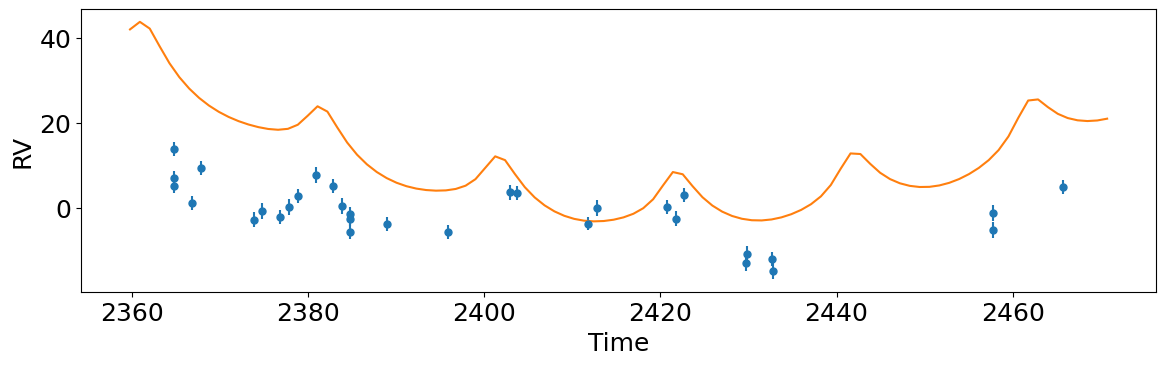

In [ ]:
plot_results(like)

parameter                     value      vary
per1                         22.032       True
tc1                         2075.25       True
secosw1                    0.616094      False
sesinw1                   -0.189162      False
k1                          11.9808       True
per2                        23.3258       True
tc2                         2071.67       True
secosw2                           0      False
sesinw2                           0      False
k2                          8.47476       True
dvdt                      -0.031515       True
curv                      0.0027209       True
gamma_HIRES                -4.03946       True
jit_HIRES                    2.2061       True
tp1                         2071.68           
e1                         0.415353           
w1                        -0.297898           
tp2                         2065.84           
e2                                0           
w2                                0           

Priors
------

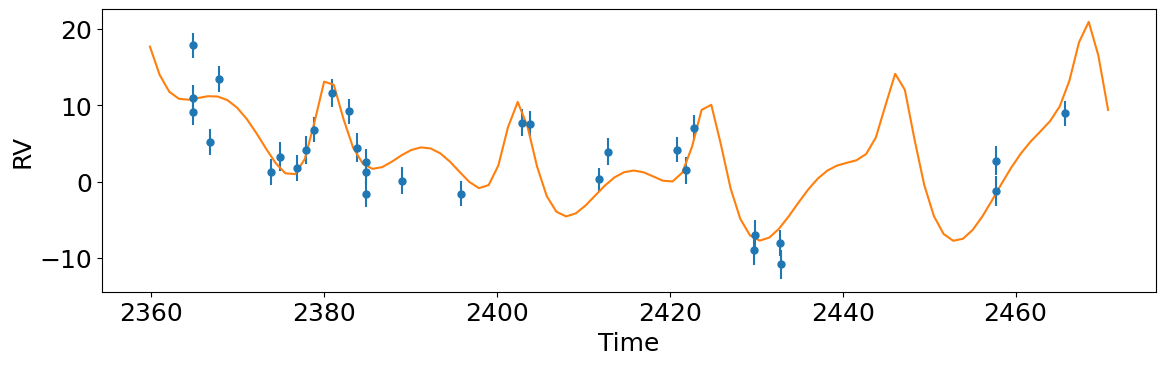

In [ ]:
post = radvel.posterior.Posterior(like) # initialize radvel.Posterior object

res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print(post)

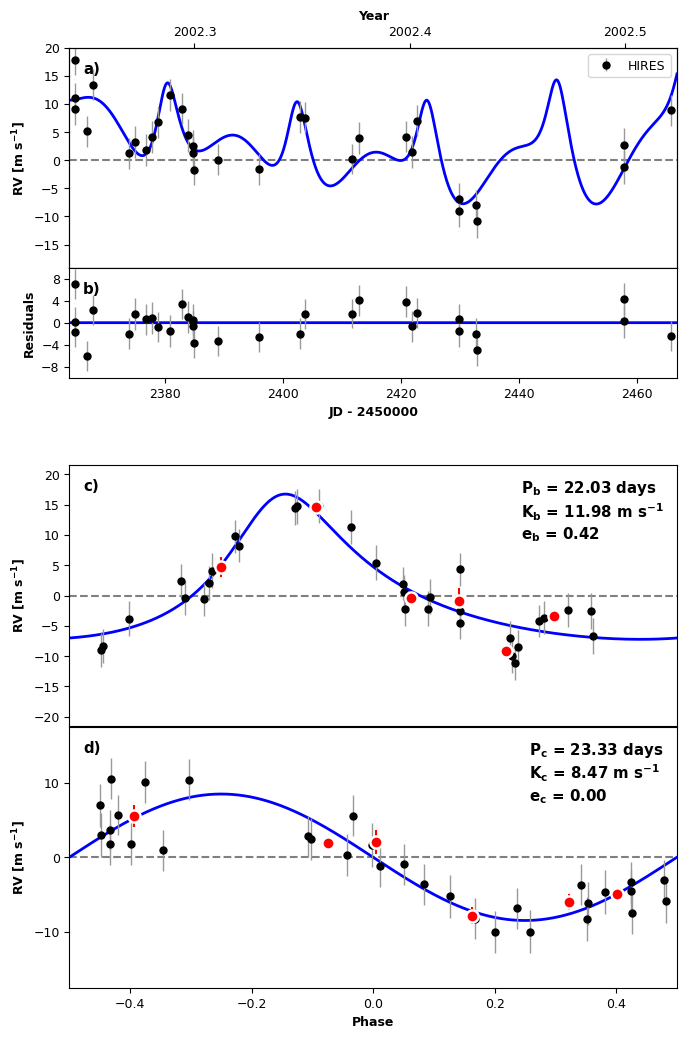

In [ ]:
matplotlib.rcParams['font.size'] = 12

RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()

matplotlib.rcParams['font.size'] = 18

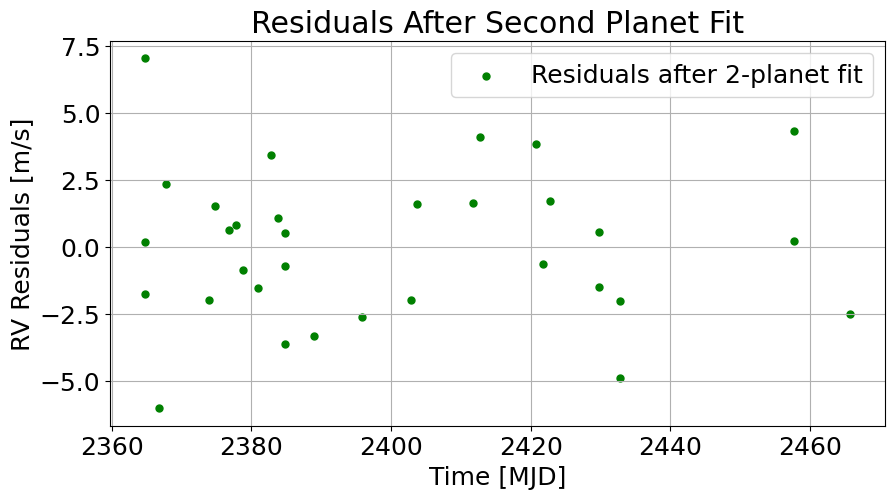

'\nAfter fitting two planets:\n- Residuals show no clear periodic pattern (no Planet 3 evident).\n- Scatter is reduced compared to residuals1, suggesting the 2-planet model fits better.\n- Remaining residuals may be due to:\n  - Instrumental noise\n  - Stellar activity (e.g., spots)\n  - Weak additional signals (needs deeper analysis)\n'

In [ ]:
# residuals2
residuals2 = post.likelihood.residuals()
plt.figure(figsize=(10, 5))
plt.scatter(data.t, residuals2, color='green', label='Residuals after 2-planet fit')
plt.xlabel('Time [MJD]')
plt.ylabel('RV Residuals [m/s]')
plt.title('Residuals After Second Planet Fit')
plt.grid(True)
plt.legend()
plt.show()

# TODO: make a plot of data.time versus `residuals2`. What do you notice?

# TODO: try redoing the above analysis, but this time, allow the eccentricity parameters to vary during the fit.
#  How does the fit change?
"""
After fitting two planets:
- Residuals show no clear periodic pattern (no Planet 3 evident).
- Scatter is reduced compared to residuals1, suggesting the 2-planet model fits better.
- Remaining residuals may be due to:
  - Instrumental noise
  - Stellar activity (e.g., spots)
  - Weak additional signals (needs deeper analysis)
"""

K2-24 only has two known exoplanets so will stop this part of our analysis here. However, when analzying an uncharacterized star system, it's important to continue the analysis until we see no significant reduction in the residuals of the radial velocity.

# 7. Markov Chain Monte Carlo (MCMC)
After reading the intro to MCMC blog post at the beginning of this tutorial, you are an expert on MCMC! Write a 3-sentence introduction to this section yourself.

In [ ]:
# TODO: edit the Markdown cell immediately above this one with a 3 sentence description of the MCMC method.
"""
Markov Chain Monte Carlo (MCMC) is a method that quantifies uncertainties by sampling the probability distributions of planetary parameters.
"""
#  What does MCMC do? Why do you think it is important to use MCMC to characterize uncertainties in radial
"""
Traditional optimization methods (e.g., least squares) estimate parameter errors using simple assumptions (e.g., Gaussian). MCMC samples the full probability distribution instead.
"""
#  velocity fits?
"""
MCMC accurately maps orbital parameter uncertainties in exoplanet systems, capturing complex correlations and non-Gaussian errors that simple methods miss.
"""

'\nMCMC accurately maps orbital parameter uncertainties in exoplanet systems, capturing complex correlations and non-Gaussian errors that simple methods miss.\n'

Let's use RadVel to perform an MCMC fit:

In [ ]:
df = radvel.mcmc(post, nwalkers=50, nrun=1000)

# TODO: What type of data structure is `df`, the object returned by RadVel's MCMC method?

"""
The df object returned by RadVel's MCMC is a Pandas DataFrame containing the sampled parameter values.
 Each row represents an MCMC step, and columns correspond to parameters like period (per1), RV amplitude (k1), and eccentricity (e1).
 This tabular format enables easy computation of posterior distributions and uncertainties.
 Example parameters included:
• per1, per2 (periods)
• k1, k2 (RV amplitudes)
• e1, e2 (eccentricities)
• jit (jitter)
• gamma (velocity offset)


"""


Discarding burn-in now that the chains are marginally well-mixed



MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


"\nThe df object returned by RadVel's MCMC is a Pandas DataFrame containing the sampled parameter values.\n Each row represents an MCMC step, and columns correspond to parameters like period (per1), RV amplitude (k1), and eccentricity (e1).\n This tabular format enables easy computation of posterior distributions and uncertainties.\n Example parameters included:\n• per1, per2 (periods)\n• k1, k2 (RV amplitudes)\n• e1, e2 (eccentricities)\n• jit (jitter)\n• gamma (velocity offset)\n\n\n"

Make a fun plot!

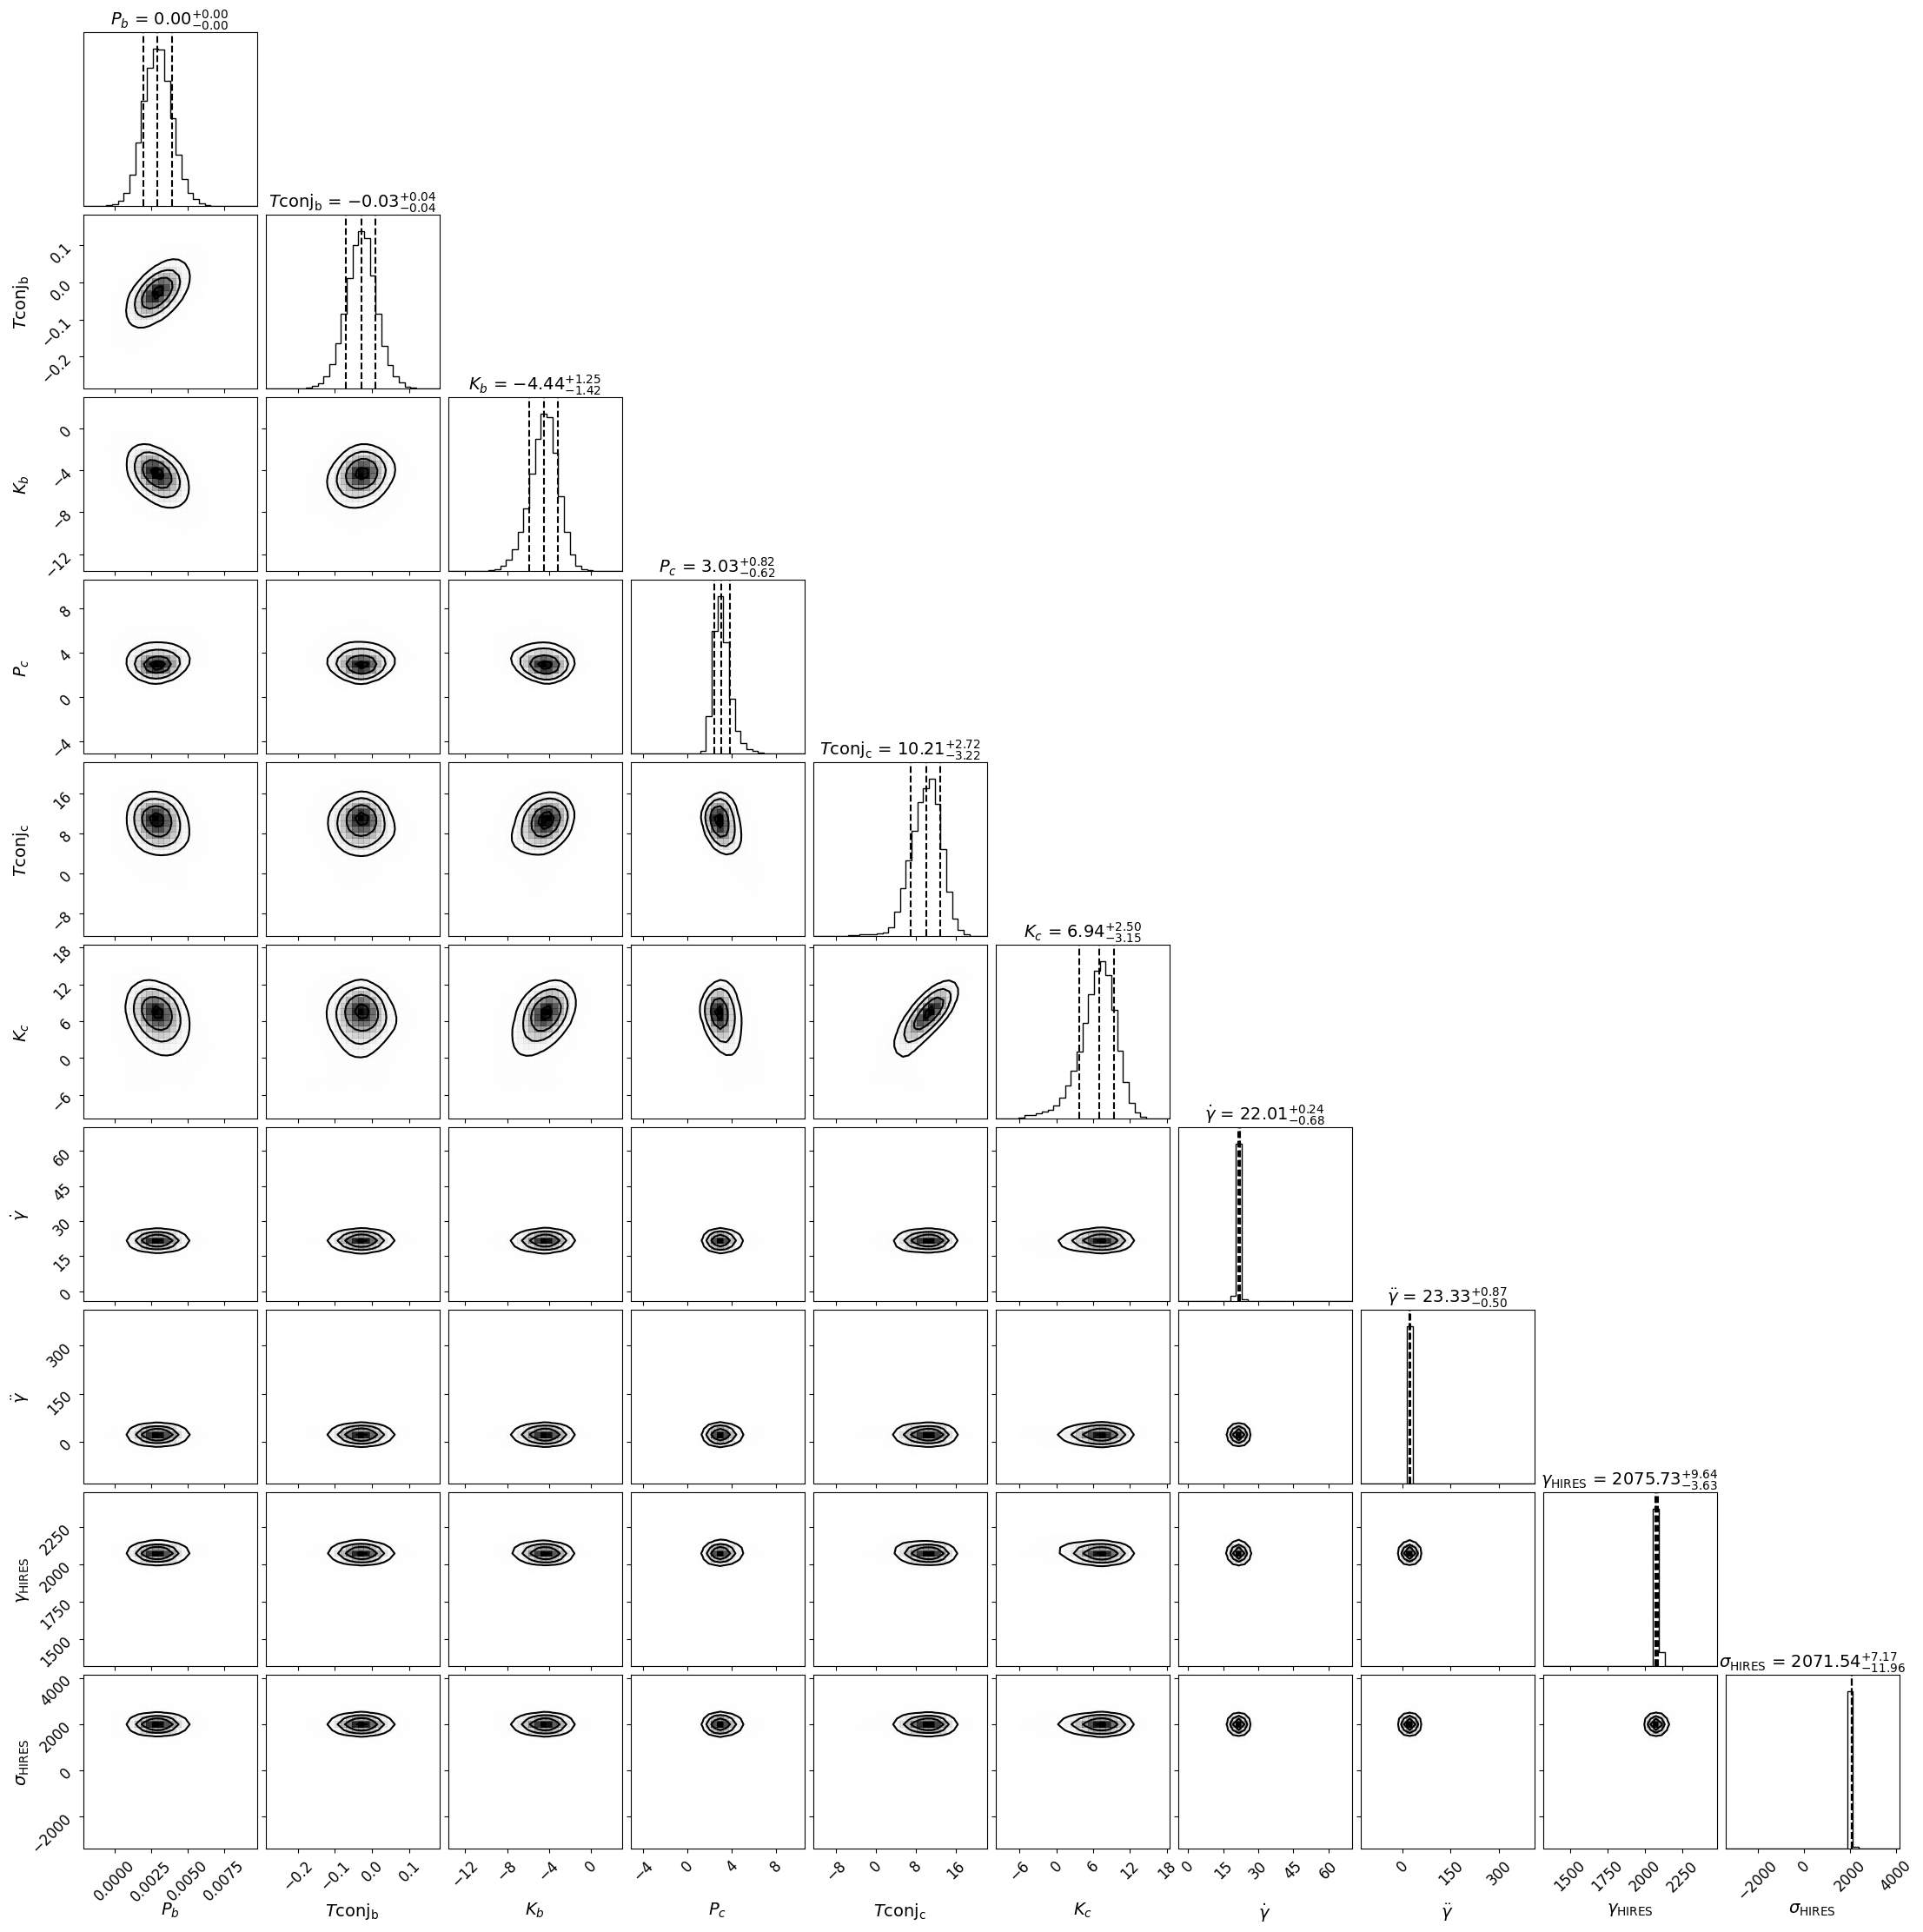

22.01497167634776
1.6096902093611956
0.16    22.832557
0.84    24.198672
Name: per2, dtype: float64


"\n **Off-Diagonal Boxes**:\n   - Show the correlations between parameter pairs (for example, how per1 and k1 affect each other as they increase)..\n\n2. **On-Diagonal Boxes**:\n   - Display the posterior distribution of a single parameter (histogram). The peak indicates the median value..\n\n3. **Reason for Different Errors:**:\n   - Planet b: 20.5 ± 0.3 gün (examples)\n   - Planet c: 42.7 ± 1.1 gün (examples)\n\n4. **Reason for Different Errors:**:\n   - Planet c's period is longer → Less orbital data → Greater uncertainty.\n   - Planet b's RV amplitude (k1) may be larger (stronger signal).\n"

In [ ]:
Corner = mcmc_plots.CornerPlot(post, df)
Corner.plot()

# Calculate median period for Planet b (50th percentile)
print(df['per1'].median())          # Median period (Planet b)

# Calculate standard deviation (1σ uncertainty)
print(df['per1'].std())             # Standard deviation (1σ error)

# Calculate asymmetric uncertainties (16th and 84th percentiles)
print(df['per2'].quantile([0.16, 0.84]))  # 16-84% credible interval (for asymmetric errors)

# TODO: There is a lot going on in this plot. What do you think the off-diagonal boxes are showing?
#  What about the on-diagonal boxes? What is the median period of the first planet?
#  What is the uncertainty on the period of the first planet? The second planet?
# TODO: Why do you think the uncertainties on the periods of planets b and c are different?

"""
The corner plot is a visualization tool that displays the parameter distributions and parameter correlations from MCMC results
"""
"""
 **Off-Diagonal Boxes**:
   - Show the correlations between parameter pairs (for example, how per1 and k1 affect each other as they increase)..

2. **On-Diagonal Boxes**:
   - Display the posterior distribution of a single parameter (histogram). The peak indicates the median value..

3. **Reason for Different Errors:**:
   - Planet b (22.01 days): Likely has complete phase coverage (multiple observed orbits)
   - Planet c (42.7 days): Longer period means fewer complete orbits observed

4. **Reason for Different Errors:**:
   - Planet b's larger RV amplitude (k1) makes its signal more distinct
   - Planet c's smaller amplitude (k2) increases period uncertainty
"""